In [1]:
import numpy as np
import operator
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def loadSimpData():
    datMat = np.matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [3]:
datMat,classLabels = loadSimpData()

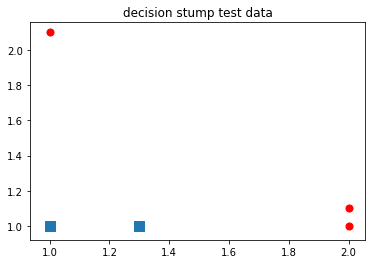

In [4]:
xcord0 = []
ycord0 = []
xcord1 = []
ycord1 = []

for i in range(len(classLabels)):
    if classLabels[i]==1.0:
        xcord1.append(datMat[i,0]), ycord1.append(datMat[i,1])
    else:
        xcord0.append(datMat[i,0]), ycord0.append(datMat[i,1])
fig = plt.figure()
ax = fig.add_subplot(111)       
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('decision stump test data')
plt.show()

In [5]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

In [6]:
def buildStump(dataArr,classLabels,D):
    dataMatrix =np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; 
    bestStump = {}; 
    bestClasEst = np.mat(np.zeros((m,1)))
    minError = np.inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); 
        rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                #call stump classify with i, j, lessThan
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D                
                if weightedError < minError:
                    #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" \
                    #   % (i, threshVal, inequal, weightedError))
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
                    # print("errArr:", errArr.T)
                    # print("bestClasEst:", bestClasEst.T)
    return bestStump,minError,bestClasEst

In [7]:
D = np.mat(np.ones((5,1)) / 5.0) #所有向量之和=1
bestStump,minError,bestClasEst = buildStump(datMat,classLabels,D)

In [8]:
bestStump,minError,bestClasEst

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [9]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)   #init D to all equal
    aggClassEst = np.mat(np.zeros((m,1)))
    errorRate = 0.0
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print "D:",D.T
        #calc alpha, throw in max(error,eps) to account for error=0
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print "classEst: ",classEst.T
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        # print("D:", D.T)
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        # print("aggClassEst:", aggClassEst.T)
        #print "aggClassEst: ",aggClassEst.T
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print ("total error: ",errorRate)
        if errorRate == 0.0: break
    return weakClassArr, aggClassEst, errorRate 

In [10]:
weakClassArr,aggClassEst,errorRate = adaBoostTrainDS(datMat, classLabels, 4)
weakClassArr,aggClassEst,errorRate

total error:  0.2
total error:  0.2
total error:  0.0


([{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
  {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
  {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]),
 0.0)

In [11]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = np.mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1))) 
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst #分类估计值的加权累加和
        #print aggClassEst
    return np.sign(aggClassEst)

In [12]:
pred = adaClassify([[2,1.8],[1.1,1]],weakClassArr)
pred

matrix([[ 1.],
        [-1.]])

In [13]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [14]:
dataArr,dataLabel = loadDataSet('horseColicTraining2.txt')
weakClassArr, aggClassEst, errorRate1 = adaBoostTrainDS(dataArr, dataLabel, 50)
weakClassArr, errorRate

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078
total error:  0.2408026755852843
total error:  0.2140468227424749
total error:  0.22742474916387959
total error:  0.21739130434782608
total error:  0.22073578595317725
total error:  0.21739130434782608
total error:  0.22408026755852842
total error:  0.22408026755852842
total error:  0.23076923076923078
total error:  0.22408026755852842
total error:  0.2140468227424749
total error:  0.20735785953177258
total error:  0.22408026755852842
total error:  0.22408026755852842
total error:  0.2140468227424749
total error:  0.22073578595317725
total error:  0.2040133779264214
total error:  0.20735785953177258
total error:  0.21070234113712374
total error:  0.2173913

([{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674},
  {'dim': 17, 'thresh': 52.5, 'ineq': 'gt', 'alpha': 0.31248245042467104},
  {'dim': 3,
   'thresh': 55.199999999999996,
   'ineq': 'gt',
   'alpha': 0.2868097320169577},
  {'dim': 18,
   'thresh': 62.300000000000004,
   'ineq': 'lt',
   'alpha': 0.23297004638939506},
  {'dim': 10, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.19803846151213741},
  {'dim': 5, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.18847887349020634},
  {'dim': 12, 'thresh': 1.2, 'ineq': 'lt', 'alpha': 0.15227368997476778},
  {'dim': 7, 'thresh': 1.2, 'ineq': 'gt', 'alpha': 0.15510870821690512},
  {'dim': 5, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.13536197353359405},
  {'dim': 4,
   'thresh': 28.799999999999997,
   'ineq': 'lt',
   'alpha': 0.12521587326132078},
  {'dim': 11, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.1334764812820767},
  {'dim': 9, 'thresh': 4.0, 'ineq': 'lt', 'alpha': 0.1418224325377107},
  {'dim': 14, 'thresh': 0.0, 'ineq': 'gt', 'alpha'

In [15]:
testArr,testLabel = loadDataSet('horseColicTest2.txt')
pred1 = adaClassify(testArr,weakClassArr)
testError = np.sum(pred1.A.ravel() != np.array(testLabel))
testError , testError / np.shape(testArr)[0] 

(14, 0.208955223880597)

In [16]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(np.array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print ("the Area Under the Curve is: ",ySum*xStep)


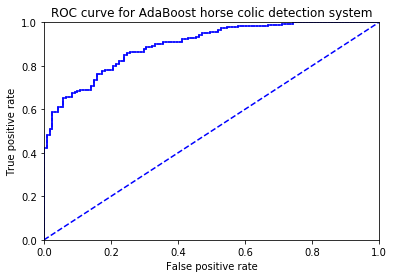

the Area Under the Curve is:  0.8953941870182941


In [17]:
plotROC(aggClassEst.T, dataLabel)